In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import gensim
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
# fetch data

df = pd.read_csv('train_X.csv')
y_df = pd.read_csv('train_y.csv')
df_test = pd.read_csv('test_X.csv')
df_test.sample(5)

,index,Content,Subject,Content-Type
3220,13925,\n\nStart Date: 10/19/01; HourAhead hour: 5; ...,Start Date: 10/19/01; HourAhead hour: 5; <COD...,"text/plain; charset=""us-ascii"""
8291,33956,\nBelow is the Enron 2002 holiday schedule. R...,2002 Holiday Schedule,text/plain;
2851,32238,"If your do not see our email in 15 seconds, pl...",[enerfaxdaily] Natural Gas Futures Up Slightly...,"text/html; charset=""iso-8859-1"""
12221,20731,That sounds great! Can you fax the 08/01 invo...,RE: Crestone Imbalance,text/plain;
8778,41948,"\n\nGood Morning,\n\nHere are this week's stat...",BNP PARIBAS Commodity Futures Weekly EIA Survey,"multipart/mixed; Boundary=""0__=K5S68iJu7Y45bJj..."


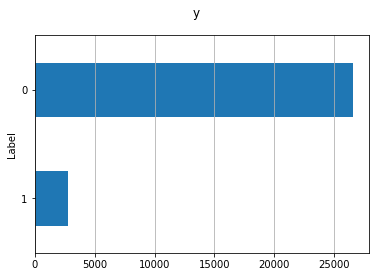

In [ ]:
# univariate distribution

fig, ax = plt.subplots()
fig.suptitle("y", fontsize=12)
y_df["Label"].reset_index().groupby("Label").count().sort_values(by= "index").plot(kind="barh", legend=False, ax=ax).grid(axis='x')
plt.show()

In [ ]:
# for cleaning text, removing stop words, and applying lemmatization

'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'([^a-zA-Z ]+?)', ' ', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [ ]:
# content_clean will hold cleaned content text combined with cleaned subject text

df["content_clean"] = (df["Subject"]+' '+ df['Content']).apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=False))
df_test["content_clean"] = (df_test["Subject"]+' '+ df_test['Content']).apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=False))
df_test.sample(5)

,index,Content,Subject,Content-Type,content_clean
11501,14182,I'm going to Bob's Halloween party on the 27th...,RE: test,"text/plain; charset=""iso-8859-1""",re test i m going to bob s halloween party on ...
6025,29071,"Michelle/Jeff,\n\nJohn Donnolly, Head of HR th...",Potential Partner HR data request,text/plain;,potential partner hr data request michelle jef...
4121,18972,"Hi everyone,\nHere we are almost at month end,...",Packets ending October 2001,text/plain;,packets ending october hi everyone here we are...
12075,20824,\n\tHere is an update on the state of play in ...,Dabhol Washington Update,text/plain;,dabhol washington update here is an update on ...
9143,3349,<html>\n<body>\n<title>PayPal</title>\n<style>...,Your PayPal Account may be at risk,text/html,your paypal account may be at risk html body t...


In [ ]:
# Set the train and test

X_train = df.copy()
y_train = y_df["Label"].values
X_test = df_test.copy()
X_train

,index,Content,Subject,Content-Type,content_clean
0,38679,What's Next for\nEnron Federal Credit Union\n\...,Credit Union Changes,text/plain;,credit union changes what s next for enron fed...
1,15230,Go ahead and decline. She is in San Fran but a...,RE: Request Submitted: Access Request for mari...,text/plain;,re request submitted access request for maria ...
2,2190,<DIV><BR><BR>\n<META http-equiv=DESCRIPTION co...,Unauthorized Access Report (Notice #21174),"text/html; charset=""Windows-1251""",unauthorized access report notice div br br me...
3,40336,\nRachael Owens\nAdmin. Assistant\nIcon Inform...,I got the timesheet..Thanks!,"multipart/alternative; boundary=""----_=_NextPa...",i got the timesheet thanks rachael owens admin...
4,13988,\n\n -----Original Message-----\nFrom: \tWrigh...,FW: Security Smart ID Tags-Off Property Usage,text/plain;,fw security smart id tags off property usage o...
...,...,...,...,...,...
29385,6265,Whatever is easiest for you. My thought would...,RE: EDS Hosting Contract,text/plain;,re eds hosting contract whatever is easiest fo...
29386,11284,\nTitle: A CERA Global Energy Conference Call ...,"Spencer Abraham, US Energy Secretary on US Ene...",text/plain,spencer abraham us energy secretary on us ener...
29387,38158,The last I heard was that you wanted legal to ...,RE: Power Documents (Final),text/plain;,re power documents final the last i heard was ...
29388,860,<DIV id=RTEContent>\n<TABLE cellSpacing=0 cell...,Question from ebay member,"text/html; charset=""Windows-1251""",question from ebay member div id rtecontent ta...


In [ ]:
# build corpus based on train for word2vec (for the competition - we can add the test data as well to enhance performnce?)

corpus = df["content_clean"]

## create list of lists of unigrams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
    lst_corpus.append(lst_grams)

bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [ ]:
# fit word2vec

nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=300, window=8, min_count=1, sg=1, iter=30)

In [ ]:
nlp

In [ ]:
# for train features, corpus with bigrams and trigrams

corpus_train = X_train["content_clean"]

## create list of lists of unigrams
lst_corpus_train = []
for string in corpus_train:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
    lst_corpus_train.append(lst_grams)
    
## detect common bigrams and trigrams using the fitted detectors
lst_corpus_train = list(bigrams_detector[lst_corpus_train])
lst_corpus_train = list(trigrams_detector[lst_corpus_train])

In [ ]:
# repeat for test features

corpus_test = X_test["content_clean"]

## create list of lists of unigrams
lst_corpus_test = []
for string in corpus_test:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
    lst_corpus_test.append(lst_grams)
    
## detect common bigrams and trigrams using the fitted detectors
lst_corpus_test = list(bigrams_detector[lst_corpus_test])
lst_corpus_test = list(trigrams_detector[lst_corpus_test])

In [ ]:
# for features extraction

def make_feature_vec(words, model, num_features):
    """
    Average the word vectors for a set of words
    """
    feature_vec = np.zeros((num_features,),dtype="float32")  # pre-initialize (for speed)
    nwords = 0
    index2word_set = set(model.wv.index2word)  # words known to the model

    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1
            feature_vec = np.add(feature_vec,model[word])
    
    feature_vec = np.divide(feature_vec, nwords)
    return feature_vec

def get_avg_feature_vecs(contents, model, num_features):
    """
    Calculate average feature vectors for all contents
    """
    counter = 0
    content_feature_vecs = np.zeros((len(contents),num_features), dtype='float32')  # pre-initialize (for speed)
    
    for content in contents:
        content_feature_vecs[counter] = make_feature_vec(content, model, num_features)
        counter = counter + 1
    
    return content_feature_vecs

In [ ]:
# calculate average feature vectors for training set

trainDataVecs = get_avg_feature_vecs(lst_corpus_train, nlp, 300)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [ ]:
# calculate average feature vectors for test set

testDataVecs = get_avg_feature_vecs(lst_corpus_test, nlp, 300)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [ ]:
# add some informative features

vecs = pd.DataFrame(trainDataVecs)
X_train_forest = pd.concat([X_train.reset_index(), vecs], axis=1)
X_train_forest['is_subject'] = np.where(X_train_forest['Subject'].isnull(), 0, 1)
X_train_forest['is_content'] = np.where(X_train_forest['Content'].isnull(), 0, 1)
X_train_forest['plain'] = np.where('text/plain' in X_train_forest['Content-Type'], 1, 0)
X_train_forest['message_len'] = X_train_forest['content_clean'].str.len()
X_train_forest.drop(columns=['level_0','index','Content','Subject','content_clean','Content-Type'],inplace=True)

vecs_test = pd.DataFrame(testDataVecs)
X_test_forest = pd.concat([X_test.reset_index(), vecs_test], axis=1)
X_test_forest['is_subject'] = np.where(X_test_forest['Subject'].isnull(), 0, 1)
X_test_forest['is_content'] = np.where(X_test_forest['Content'].isnull(), 0, 1)
X_test_forest['plain'] = np.where('text/plain' in X_test_forest['Content-Type'], 1, 0)
X_test_forest['message_len'] = X_test_forest['content_clean'].str.len()
X_test_forest.drop(columns=['level_0','index','Content','Subject','content_clean','Content-Type'],inplace=True)

In [ ]:
X_test_forest

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,is_subject,is_content,plain,message_len
0,-0.000352,-0.007393,0.065515,0.180782,-0.215982,-0.056020,0.122353,-0.058819,-0.118524,-0.128101,0.129950,0.103707,0.091936,-0.157042,-0.132550,-0.022104,0.075259,-0.161283,-0.075899,-0.052050,0.034757,-0.000875,0.148881,0.084733,-0.180995,-0.063605,-0.098019,-0.142430,-0.058921,-0.007563,0.030067,0.113984,0.126656,0.107651,-0.117074,-0.150730,0.024219,-0.047446,0.167503,0.184055,...,-0.143826,-0.033649,0.015108,0.078591,-0.133778,-0.005344,0.021482,-0.001416,0.035731,0.088865,-0.022883,-0.096843,0.062614,-0.035510,-0.148312,0.079376,-0.134248,-0.110343,-0.214538,-0.065438,-0.223971,0.141823,0.028364,-0.093138,0.070357,-0.010022,-0.149519,0.173396,-0.175016,0.003539,-0.048494,-0.167963,-0.133603,0.073122,-0.230373,0.058860,1,1,0,892
1,0.026276,-0.049403,0.067719,0.174698,-0.182711,-0.002358,0.075926,-0.027261,-0.111267,-0.112391,0.102214,0.080362,0.113225,-0.019708,-0.144261,-0.011729,0.054306,-0.198732,-0.063464,0.013137,0.052759,-0.012237,0.069599,0.087450,-0.190405,-0.044691,-0.070602,-0.110969,-0.170442,-0.011698,0.031292,0.100461,0.176702,0.054891,-0.148733,-0.118503,0.043545,-0.079774,0.177626,0.222423,...,-0.199885,-0.140785,-0.021844,0.114108,-0.139721,-0.049640,0.100275,0.033199,-0.016136,0.094384,0.003776,-0.038320,0.072364,-0.040105,-0.086163,0.107372,-0.100394,-0.088156,-0.158217,-0.060154,-0.217151,0.157964,0.005134,-0.071138,0.152181,0.010414,-0.140463,0.192419,-0.105831,0.011025,-0.013548,-0.159896,-0.110335,0.045549,-0.256905,-0.051627,1,1,0,716
2,-0.045060,0.003624,0.016915,0.179286,-0.214893,0.008744,0.164030,-0.021101,-0.094558,-0.169633,0.126734,0.131919,0.046429,-0.112660,-0.180138,-0.001549,0.044768,-0.196571,-0.073499,-0.065194,0.127001,0.015015,-0.006905,0.129142,-0.224624,-0.030168,-0.138916,-0.098754,-0.145295,-0.076686,0.125394,0.075584,0.164154,0.067825,-0.136551,-0.076634,0.021113,-0.038157,0.145471,0.206172,...,-0.178533,-0.088058,-0.100764,0.098051,-0.073470,-0.039654,0.129181,-0.037450,0.065650,0.073119,-0.101971,-0.079894,0.039091,-0.063583,-0.121315,0.128465,-0.155055,-0.175329,-0.200363,0.015906,-0.122069,0.046724,-0.045424,-0.072432,0.238802,-0.012282,-0.048772,0.189139,-0.127764,-0.048330,-0.094715,-0.178182,-0.037512,0.010682,-0.263799,0.060290,1,1,0,970
3,0.040656,-0.042603,0.117056,0.141199,-0.127884,0.018359,0.229989,-0.074821,-0.010726,-0.104657,0.154308,0.011742,0.152214,-0.168784,-0.112348,0.058526,0.108392,-0.099626,0.005384,-0.066294,0.082263,0.011723,0.089743,0.138063,-0.184913,-0.117397,-0.032507,-0.083534,-0.112161,0.055647,0.028519,0.074349,0.075581,0.084884,-0.108339,-0.232994,-0.016941,-0.142571,0.083612,0.082349,...,-0.014208,-0.113954,0.020030,0.067614,-0.228493,-0.036104,0.162721,0.065214,-0.006981,0.245704,-0.058957,-0.088915,0.135866,-0.103939,-0.065187,0.070446,-0.146533,-0.171606,-0.216433,-0.061781,-0.258450,0.057048,-0.097627,-0.180415,0.168086,0.030159,-0.212217,0.175828,-0.130880,-0.029961,-0.090006,-0.164806,-0.086314,0.203129,-0.295155,0.032443,1,1,0,426
4,-0.104504,0.016419,0.107638,0.035129,-0.184075,0.025327,0.286033,0.251158,-0.200640,-0.152044,-0.110370,-0.036429,0.190868,-0.161006,-0.152495,-0.030545,0.084900,-0.168884,0.088949,0.030458,0.231949,-0.144674,0.167055,0.063528,-0.149112,-0.121170,-0.072522,-0.129402,-0.134858,-0.173233,0.274331,-0.023027,0.088145,-0.016008,-0.228666,0.060595,-0.069143,0.021964,0.311030,0.024605,...,-0.031254,-0.139214,-0.007287,-0.014495,-0.044357,-0.081522,0.076546,-0.043898,0.195811,0.012563,0.029822,0.009177,-0.136768,-0.083807,0.224672,0.025772,-0.107808,-0.215163,-0.035783,0.144397,-0.309770,0.086862,0.167571,-0.315052,0.108058,0.155988,0.019119,0.178327,-0.270457,-0.025422,-0.000879,-0.367525,-0.142967,0.089043,-0.298620,0.098

In [ ]:
# treat nulls

X_train_forest.fillna(0, inplace=True)
X_test_forest.fillna(0, inplace=True)

In [ ]:
# fit adaboost and predict

clf = AdaBoostClassifier(n_estimators=4000, random_state=0,learning_rate=0.1)
clf.fit(X_train_forest, y_train)

pred_y_forest= clf.predict(X_test_forest)
len(clf.estimators_)

4000

In [ ]:
pred_y_forest

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# build the results set

preds_df = pd.DataFrame(pred_y_forest)
X_results = pd.concat([X_test.reset_index(), preds_df], axis=1)
X_results[X_results.iloc[:,-1]==1]

,level_0,index,Content,Subject,Content-Type,0
11,11,655,<html>\n<head>\n<title></title>\n<meta http-eq...,Notification,"text/html; charset=""Windows-1251""",1
26,26,343,<!--StartFragment --><HTML><HEAD>\n<META http-...,Amazon Notice: Error on file,text/html,1
43,43,3269,<P>\n<TABLE cellSpacing=0 cellPadding=5 width=...,eBay-Security & Resolution center,text/html,1
59,59,3150,"\t<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0...",Notification:Your Online Account Needs Re-acti...,"text/html; charset=""us-ascii""",1
126,126,3519,\n<table border=0 cellspacing=8 cellpadding=0 ...,Notfication of e-gold Payment,text/html,1
...,...,...,...,...,...,...
12550,12550,3690,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.01 T...",Homeland Security Co AIMT signs Critical U.S. ...,"multipart/alternative; boundary=""=_NextPart_2r...",1
12557,12557,2208,"</FONT> <div></div> <DIV bgcolor=""#FFFFFF"">...",eBay Email Confirmation - Response Required,"text/html; charset=""Windows-1251""",1
12571,12571,2298,<html>\n<head>\n<title>NCUA</title>\n</head>\n...,FCU NOTICE: Important security renewal,"multipart/alternative; boundary=""--61456331238...",1
12579,12579,2388,"<div id=""message"">\n <table cellSpacing=""0"" c...",Win the best car Viper SRT-10 offered by eBay.com,"text/html; charset=""Windows-1251""",1


In [ ]:
X_results.drop(columns=['level_0','Content','Subject','Content-Type'],inplace=True)
X_results

,index,0
0,27922,0
1,34515,0
2,34713,0
3,37590,0
4,29837,0
...,...,...
12591,14615,0
12592,6067,0
12593,8094,0
12594,35356,0


In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
X_results.to_csv('submission4.csv')
!cp submission4.csv "drive/My Drive/"